In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from qr_decomposition.decomposition import projection_matrix, qr_decomposition
from qr_decomposition.utils import resolve_path

In [3]:
dataset_path = resolve_path("dataset/imdb_reviews.parquet")
train_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'train'").to_df()
val_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'val'").to_df()

len(train_df), len(val_df)

(39899, 10101)

In [4]:
def print_pca_stats(pca_data):
    for i in range(2):  # for first two PCs
        print(f"\nPC{i + 1} Statistics:")
        print(f"Mean: {np.mean(pca_data[:, i]):.3f}")
        print(f"Std: {np.std(pca_data[:, i]):.3f}")
        print(f"Min: {np.min(pca_data[:, i]):.3f}")
        print(f"Max: {np.max(pca_data[:, i]):.3f}")
        print(f"25th percentile: {np.percentile(pca_data[:, i], 25):.3f}")
        print(f"Median: {np.median(pca_data[:, i]):.3f}")
        print(f"75th percentile: {np.percentile(pca_data[:, i], 75):.3f}")

In [5]:
val_X = val_df["embeddings"]
val_X = np.array([np.array(emb) for emb in val_X])
val_X_labels = val_df["sentiment"]
val_X.shape

(10101, 1536)

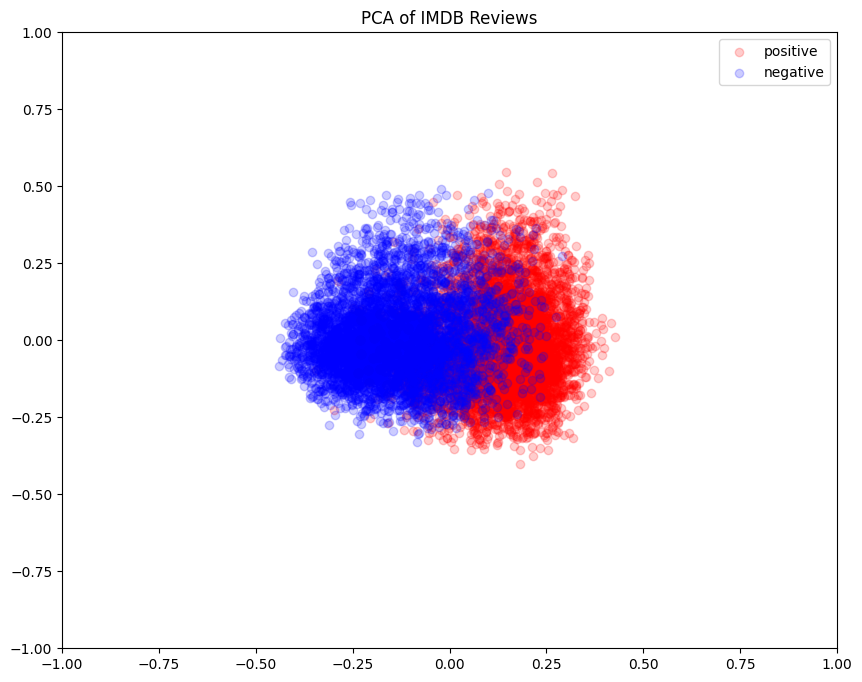

In [6]:
pca = PCA(n_components=2)
val_X_pca = pca.fit_transform(val_X)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_pca[positive_mask, 0], val_X_pca[positive_mask, 1], c="red", alpha=0.2, label="positive"
)
plt.scatter(
    val_X_pca[negative_mask, 0], val_X_pca[negative_mask, 1], c="blue", alpha=0.2, label="negative"
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of IMDB Reviews")
plt.show()

In [7]:
print_pca_stats(val_X_pca)


PC1 Statistics:
Mean: -0.000
Std: 0.183
Min: -0.439
Max: 0.426
25th percentile: -0.149
Median: 0.014
75th percentile: 0.153

PC2 Statistics:
Mean: -0.000
Std: 0.148
Min: -0.401
Max: 0.547
25th percentile: -0.105
Median: -0.016
75th percentile: 0.089


In [8]:
positive_train_df = train_df[train_df["sentiment"] == "negative"]
len(positive_train_df)

19877

In [9]:
# train the projection matrix
train_X = np.array([np.array(emb) for emb in positive_train_df["embeddings"]])
Q, R = qr_decomposition(train_X)
train_X_proj = projection_matrix(Q)
train_X_proj.shape

(1536, 1536)

In [10]:
# project the validation data onto the train_X_proj
val_X_pos_subspace = val_X @ train_X_proj
val_X_pos_subspace.shape

(10101, 1536)

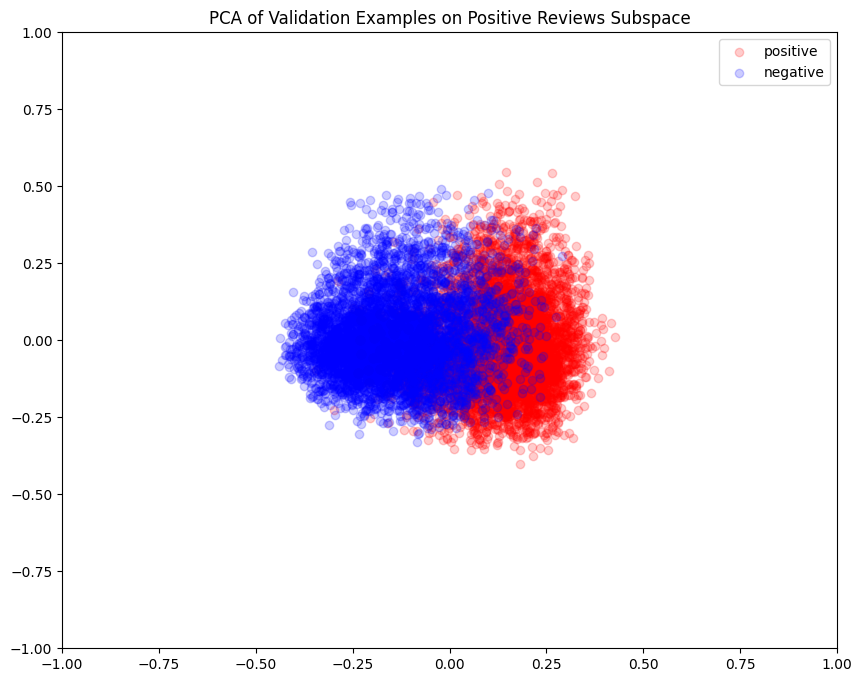

In [11]:
pca = PCA(n_components=2)
val_X_pos_subspace_pca = pca.fit_transform(val_X_pos_subspace)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_pos_subspace_pca[positive_mask, 0],
    val_X_pos_subspace_pca[positive_mask, 1],
    c="red",
    alpha=0.2,
    label="positive",
)
plt.scatter(
    val_X_pos_subspace_pca[negative_mask, 0],
    val_X_pos_subspace_pca[negative_mask, 1],
    c="blue",
    alpha=0.2,
    label="negative",
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of Validation Examples on Positive Reviews Subspace")
plt.show()

In [12]:
print_pca_stats(val_X_pos_subspace_pca)


PC1 Statistics:
Mean: 0.000
Std: 0.183
Min: -0.439
Max: 0.426
25th percentile: -0.149
Median: 0.014
75th percentile: 0.153

PC2 Statistics:
Mean: -0.000
Std: 0.148
Min: -0.400
Max: 0.547
25th percentile: -0.105
Median: -0.016
75th percentile: 0.089


In [13]:
# remove the projected subspace from the validation data
val_X_proj_pca_removed = val_X - val_X_pos_subspace
val_X_proj_pca_removed.shape

(10101, 1536)

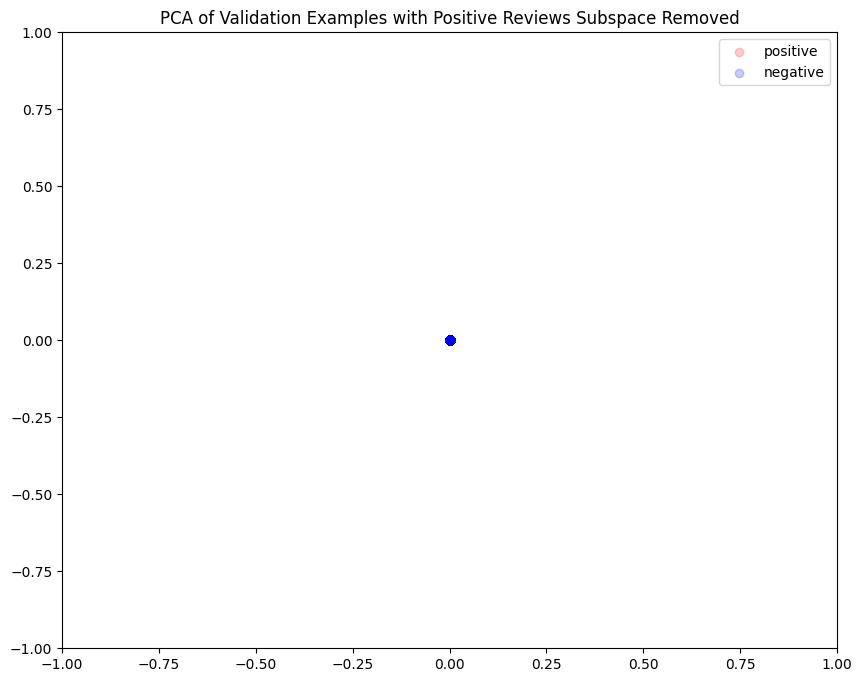

In [14]:
pca = PCA(n_components=2)
val_X_proj_pca_removed_pca = pca.fit_transform(val_X_proj_pca_removed)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_proj_pca_removed_pca[positive_mask, 0],
    val_X_proj_pca_removed_pca[positive_mask, 1],
    c="red",
    alpha=0.2,
    label="positive",
)
plt.scatter(
    val_X_proj_pca_removed_pca[negative_mask, 0],
    val_X_proj_pca_removed_pca[negative_mask, 1],
    c="blue",
    alpha=0.2,
    label="negative",
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of Validation Examples with Positive Reviews Subspace Removed")
plt.show()

In [15]:
print_pca_stats(val_X_proj_pca_removed_pca)


PC1 Statistics:
Mean: 0.000
Std: 0.000
Min: -0.000
Max: 0.000
25th percentile: -0.000
Median: -0.000
75th percentile: 0.000

PC2 Statistics:
Mean: -0.000
Std: 0.000
Min: -0.000
Max: 0.000
25th percentile: -0.000
Median: 0.000
75th percentile: 0.000
